# Method A

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
train_df = pd.read_parquet("train.parquet")
test_df  = pd.read_parquet("test.parquet")

In [3]:
def prep_logs(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["userId"] = df["userId"].astype(int)
    df["time"] = pd.to_datetime(df["time"], errors="coerce")
    df["registration"] = pd.to_datetime(df["registration"], errors="coerce")
    df = df.set_index("userId")
    return df

train_df = prep_logs(train_df)
test_df  = prep_logs(test_df)

In [4]:
def study_cancel_to_confirm_delta_minutes(train_logs: pd.DataFrame) -> pd.Series:
    """
    Compute the time difference (in minutes) between the last 'Cancel'
    and the first 'Cancellation Confirmation' for churned users.

    Assumes:
    - userId is the index
    - 'time' is datetime
    """

    # earliest confirmation per user
    conf_time = (
        train_logs[train_logs["page"] == "Cancellation Confirmation"]
        .groupby(level=0)["time"]
        .min()
    )

    # all Cancel events before confirmation
    cancel_events = train_logs[train_logs["page"] == "Cancel"][["time"]].copy()
    cancel_events = cancel_events.join(conf_time.rename("conf_time"), how="inner")

    cancel_events = cancel_events[cancel_events["time"] < cancel_events["conf_time"]]

    # last Cancel before confirmation
    last_cancel = cancel_events.groupby(level=0)["time"].max()

    # delta in minutes
    delta_minutes = (
        conf_time.loc[last_cancel.index] - last_cancel
    ).dt.total_seconds() / 60

    delta_minutes.name = "cancel_to_confirm_minutes"
    return delta_minutes

delta_minutes = study_cancel_to_confirm_delta_minutes(train_df)
print(delta_minutes.describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99]))


count    4148.000000
mean        1.540996
std         3.113249
min         0.016667
50%         0.566667
75%         1.583333
90%         3.800000
95%         5.850000
99%        14.259833
max        62.000000
Name: cancel_to_confirm_minutes, dtype: float64


In [5]:
GLOBAL_CUTOFF = pd.Timestamp("2018-11-20")

# default buffer in minutes (only applied to churn users in TRAIN)
BUFFER_MINUTES = 0

def build_user_anchors(train_logs: pd.DataFrame, buffer_minutes: int = BUFFER_MINUTES) -> pd.DataFrame:
    # churn_time = earliest Cancellation Confirmation
    churn_dates = (
        train_logs[train_logs["page"] == "Cancellation Confirmation"]
        .groupby(level=0)["time"].min()
    )

    # apply buffer only to churn users
    if buffer_minutes and buffer_minutes > 0:
        churn_dates = churn_dates - pd.Timedelta(minutes=buffer_minutes)

    all_users = train_logs.index.unique()
    user_anchors = pd.DataFrame(index=all_users)

    def get_anchor(uid):
        return churn_dates.loc[uid] if uid in churn_dates.index else GLOBAL_CUTOFF

    user_anchors["anchor_date"] = user_anchors.index.to_series().apply(get_anchor)
    user_anchors["target_x"] = user_anchors.index.to_series().apply(lambda uid: 1 if uid in churn_dates.index else 0)

    # safety: anchor_date cannot be earlier than registration
    # (needed only for churn users after subtracting buffer)
    reg = train_logs.groupby(level=0)["registration"].min()
    user_anchors["registration"] = reg.reindex(all_users)
    user_anchors["anchor_date"] = user_anchors[["anchor_date", "registration"]].max(axis=1)

    # drop helper registration column to keep rest identical to your pipeline
    user_anchors = user_anchors.drop(columns=["registration"], errors="ignore")

    return user_anchors

user_anchors = build_user_anchors(train_df, buffer_minutes=BUFFER_MINUTES)

In [6]:
def make_train_valid_logs(train_logs: pd.DataFrame, user_anchors: pd.DataFrame, window_days: int = 10) -> pd.DataFrame:
    # merge anchor_date/target_x into logs (by index userId)
    merged = train_logs.merge(user_anchors, left_index=True, right_index=True, how="left")

    # keep logs strictly before anchor_date (removes confirmation itself)
    valid = merged[merged["time"] < merged["anchor_date"]].copy()

    # keep only last window_days
    valid = valid[valid["time"] > (valid["anchor_date"] - pd.Timedelta(days=window_days))].copy()

    # day column used by teammate
    valid["day"] = pd.to_datetime(valid["time"]).dt.date

    return valid

valid_logs_train = make_train_valid_logs(train_df, user_anchors, window_days=20)

In [7]:
def aggregate_features(logs_df: pd.DataFrame) -> pd.DataFrame:
    logs_df = logs_df.copy()

    # 1) page counts pivot
    behavior_counts = logs_df.groupby([pd.Grouper(level=0), "page"]).size().unstack(fill_value=0)
    behavior_counts.columns = ["count_" + col.replace(" ", "_") for col in behavior_counts.columns]

    # 2) stats
    if "length" in logs_df.columns:
        logs_df["length"] = pd.to_numeric(logs_df["length"], errors="coerce")
        length_sum = logs_df.groupby(level=0)["length"].sum().rename("length_sum")
    else:
        length_sum = pd.Series(0, index=logs_df.index.unique(), name="length_sum")

    stats_features = logs_df.groupby(level=0).agg(
        num_sessions=("sessionId", "nunique"),
        active_days=("day", "nunique"),
        total_interactions=("page", "count"),
    )
    stats_features = stats_features.join(length_sum, how="left").fillna({"length_sum": 0})

    # 3) static cols (take last)
    static_cols = ["gender", "level", "registration", "anchor_date", "target_x"]
    static_cols = [c for c in static_cols if c in logs_df.columns]
    user_profile = logs_df.groupby(level=0)[static_cols].last()

    # 4) merge all
    final_df = pd.concat([user_profile, behavior_counts, stats_features], axis=1)

    # 5) feature engineering
    if "registration" in final_df.columns and "anchor_date" in final_df.columns:
        final_df["tenure_days"] = (final_df["anchor_date"] - final_df["registration"]).dt.days
    else:
        final_df["tenure_days"] = 0

    if "count_NextSong" in final_df.columns:
        final_df["songs_per_session"] = final_df["count_NextSong"] / (final_df["num_sessions"] + 1e-9)
    else:
        final_df["songs_per_session"] = 0.0

    if "gender" in final_df.columns:
        final_df["gender_code"] = (final_df["gender"] == "M").astype(int)
    else:
        final_df["gender_code"] = 0

    if "level" in final_df.columns:
        final_df["level_code"] = (final_df["level"] == "paid").astype(int)
    else:
        final_df["level_code"] = 0

    final_df["avg_daily_listen_time"] = final_df["length_sum"] / (final_df["active_days"] + 1e-9)

    # recent trend (last 3 days)
    logs_df["day_diff"] = (logs_df["anchor_date"] - logs_df["time"]).dt.days
    recent_activity = logs_df[logs_df["day_diff"] <= 3].groupby(level=0).size().rename("last_3_days_count")
    final_df = final_df.join(recent_activity, how="left").fillna({"last_3_days_count": 0})

    final_df["recent_trend"] = final_df["last_3_days_count"] / (final_df["total_interactions"] + 1)

    # 6) cleanup (same spirit as teammate)
    drop_cols = ["gender", "level", "registration", "anchor_date"]
    final_df = final_df.drop(columns=drop_cols, errors="ignore")

    return final_df.fillna(0)

In [8]:
train_data_final = aggregate_features(valid_logs_train)

In [9]:
train_data_final.columns

Index(['target_x', 'count_About', 'count_Add_Friend', 'count_Add_to_Playlist',
       'count_Cancel', 'count_Downgrade', 'count_Error', 'count_Help',
       'count_Home', 'count_Logout', 'count_NextSong', 'count_Roll_Advert',
       'count_Save_Settings', 'count_Settings', 'count_Submit_Downgrade',
       'count_Submit_Upgrade', 'count_Thumbs_Down', 'count_Thumbs_Up',
       'count_Upgrade', 'num_sessions', 'active_days', 'total_interactions',
       'length_sum', 'tenure_days', 'songs_per_session', 'gender_code',
       'level_code', 'avg_daily_listen_time', 'last_3_days_count',
       'recent_trend'],
      dtype='object')

In [10]:
y = train_data_final["target_x"].astype(int)
X = train_data_final.drop(columns=["target_x"], errors="ignore")

In [11]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

In [12]:
lr_model = LogisticRegression(
    class_weight="balanced",
    max_iter=3000,
    random_state=42
)

selector = RFE(estimator=lr_model, n_features_to_select=18, step=1)
selector.fit(X_train_scaled, y_train)

selected_features = X_train.columns[selector.support_].tolist()
print("Selected features:", selected_features)

# transform
X_train_sel = selector.transform(X_train_scaled)
X_val_sel   = selector.transform(X_val_scaled)

# fit
lr_model.fit(X_train_sel, y_train)

val_pred = lr_model.predict(X_val_sel)
print(classification_report(y_val, val_pred, digits=4, zero_division=0))
print(confusion_matrix(y_val, val_pred))

Selected features: ['count_About', 'count_Add_Friend', 'count_Cancel', 'count_Downgrade', 'count_Home', 'count_NextSong', 'count_Roll_Advert', 'count_Settings', 'count_Submit_Downgrade', 'count_Submit_Upgrade', 'count_Thumbs_Down', 'count_Upgrade', 'active_days', 'total_interactions', 'length_sum', 'tenure_days', 'level_code', 'recent_trend']
              precision    recall  f1-score   support

           0     0.9900    0.9985    0.9943      2686
           1     0.9952    0.9684    0.9816       854

    accuracy                         0.9912      3540
   macro avg     0.9926    0.9834    0.9879      3540
weighted avg     0.9913    0.9912    0.9912      3540

[[2682    4]
 [  27  827]]


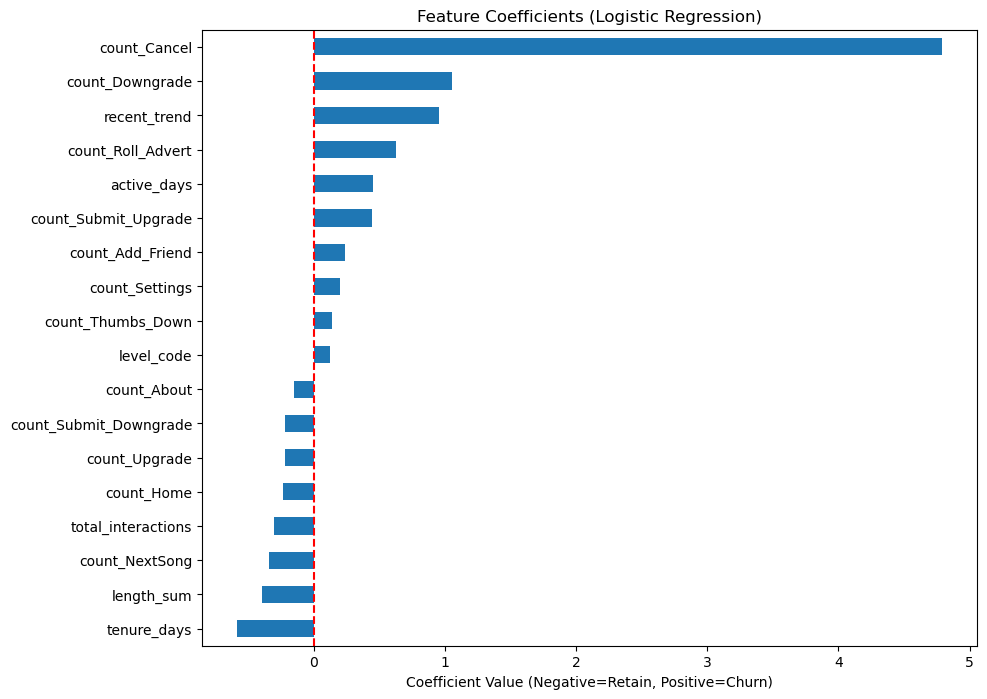

In [13]:
coefs = pd.Series(lr_model.coef_[0], index=selected_features)
coefs_sorted = coefs.sort_values()
plt.figure(figsize=(10, 8))
coefs_sorted.plot(kind='barh')
plt.title("Feature Coefficients (Logistic Regression)")
plt.xlabel("Coefficient Value (Negative=Retain, Positive=Churn)")
plt.axvline(x=0, color='red', linestyle='--')
plt.show()

In [14]:
def make_test_valid_logs_full_history(test_logs: pd.DataFrame) -> pd.DataFrame:
    valid = test_logs.copy()
    max_date = valid["time"].max()
    valid["anchor_date"] = max_date
    valid["target_x"] = 0  # dummy, to reuse aggregate_features
    valid["day"] = pd.to_datetime(valid["time"]).dt.date
    return valid

test_valid_logs = make_test_valid_logs_full_history(test_df)
test_data_final = aggregate_features(test_valid_logs)

In [15]:
# Build X_test with EXACT same columns as X_train
X_test = test_data_final.drop(columns=["target_x"], errors="ignore")

# align columns: any missing feature -> 0, any extra feature -> dropped automatically
X_test_aligned = X_test.reindex(columns=X.columns, fill_value=0)

# scale using TRAIN scaler (NOT fit on test!)
X_test_scaled = scaler.transform(X_test_aligned)

# apply same selected features mask (RFE)
X_test_sel = selector.transform(X_test_scaled)

In [16]:
test_pred = lr_model.predict(X_test_sel)

submission = pd.DataFrame({
    "id": X_test_aligned.index.astype(int),
    "target": test_pred.astype(int)
})

submission.to_csv("submission_modified_18_win9.csv", index=False)
submission.head()

,id,target
0,1000655,0
1,1000963,0
2,1001129,0
3,1001963,0
4,1002283,0


# Method B

In [17]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report, confusion_matrix

In [18]:
train_df = pd.read_parquet("train.parquet")
test_df  = pd.read_parquet("test.parquet")

In [19]:
def prep_logs(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["userId"] = df["userId"].astype(int)
    df["time"] = pd.to_datetime(df["time"], errors="coerce")
    df["registration"] = pd.to_datetime(df["registration"], errors="coerce")
    df = df.set_index("userId")
    return df

train_df = prep_logs(train_df)
test_df  = prep_logs(test_df)

In [20]:
LASTDATE = pd.Timestamp("2018-11-20")
CHURN_WINDOW_DAYS = 10

# churn window start = lastdate - 10 days
CHURN_WINDOW_START = LASTDATE - pd.Timedelta(days=CHURN_WINDOW_DAYS)

# 你说：drop 掉 churn 在 2018-11-11 之前的用户（严格早于 2018-11-11）
DROP_BEFORE = pd.Timestamp("2018-11-11")

# 用于提取训练特征的“可变窗口天数”，默认 10（你可改）
LOOKBACK_DAYS = 30

In [21]:
def build_user_anchors_fixed_window(train_logs: pd.DataFrame) -> pd.DataFrame:
    """
    Fix churn window: (LASTDATE-10d, LASTDATE]
    1) Record user's earliest Cancellation Confirmation time churn_date（NaT for not churn）
    2) drop churn_date < DROP_BEFORE
    3) Remaining：
       - anchor_date as CHURN_WINDOW_START（LASTDATE-10d）
       - target_x = 1 if churn_date 在in[DROP_BEFORE, LASTDATE]，otherwise 0
    """
    churn_dates = (
        train_logs[train_logs["page"] == "Cancellation Confirmation"]
        .groupby(level=0)["time"].min()
    )

    all_users = train_logs.index.unique()
    user_anchors = pd.DataFrame(index=all_users)
    user_anchors.index.name = "userId"

    user_anchors["churn_date"] = churn_dates.reindex(all_users)

    # drop：before 2018-11-11 churn
    keep_mask = user_anchors["churn_date"].isna() | (user_anchors["churn_date"] >= DROP_BEFORE)
    user_anchors = user_anchors.loc[keep_mask].copy()

    # Fix anchor_date
    user_anchors["anchor_date"] = CHURN_WINDOW_START

    # label
    in_window = user_anchors["churn_date"].notna() & (user_anchors["churn_date"] <= LASTDATE)
    user_anchors["target_x"] = in_window.astype(int)

    return user_anchors


user_anchors = build_user_anchors_fixed_window(train_df)

In [22]:
def make_train_valid_logs_fixed_window(
    train_logs: pd.DataFrame,
    user_anchors: pd.DataFrame,
    lookback_days: int = 10
) -> pd.DataFrame:
    """
    Only use to train features：
    (anchor_date - lookback_days, anchor_date)
    and anchor_date for（CHURN_WINDOW_START）
    """
    merged = train_logs.merge(user_anchors[["anchor_date", "target_x"]], left_index=True, right_index=True, how="inner")

    # Remain information before anchor_date
    valid = merged[merged["time"] < merged["anchor_date"]].copy()

    # Only remain changable lookback
    valid = valid[valid["time"] > (valid["anchor_date"] - pd.Timedelta(days=lookback_days))].copy()

    valid["day"] = pd.to_datetime(valid["time"]).dt.date
    return valid


valid_logs_train = make_train_valid_logs_fixed_window(train_df, user_anchors, lookback_days=LOOKBACK_DAYS)

In [23]:
def aggregate_features(logs_df: pd.DataFrame) -> pd.DataFrame:
    logs_df = logs_df.copy()

    # 1) page counts pivot
    behavior_counts = logs_df.groupby([pd.Grouper(level=0), "page"]).size().unstack(fill_value=0)
    behavior_counts.columns = ["count_" + col.replace(" ", "_") for col in behavior_counts.columns]

    # 2) stats
    if "length" in logs_df.columns:
        logs_df["length"] = pd.to_numeric(logs_df["length"], errors="coerce")
        length_sum = logs_df.groupby(level=0)["length"].sum().rename("length_sum")
    else:
        length_sum = pd.Series(0, index=logs_df.index.unique(), name="length_sum")

    stats_features = logs_df.groupby(level=0).agg(
        num_sessions=("sessionId", "nunique"),
        active_days=("day", "nunique"),
        total_interactions=("page", "count"),
    )
    stats_features = stats_features.join(length_sum, how="left").fillna({"length_sum": 0})

    # 3) static cols (take last)
    static_cols = ["gender", "level", "registration", "anchor_date", "target_x"]
    static_cols = [c for c in static_cols if c in logs_df.columns]
    user_profile = logs_df.groupby(level=0)[static_cols].last()

    # 4) merge all
    final_df = pd.concat([user_profile, behavior_counts, stats_features], axis=1)

    # 5) feature engineering
    if "registration" in final_df.columns and "anchor_date" in final_df.columns:
        final_df["tenure_days"] = (final_df["anchor_date"] - final_df["registration"]).dt.days
    else:
        final_df["tenure_days"] = 0

    if "count_NextSong" in final_df.columns:
        final_df["songs_per_session"] = final_df["count_NextSong"] / (final_df["num_sessions"] + 1e-9)
    else:
        final_df["songs_per_session"] = 0.0

    if "gender" in final_df.columns:
        final_df["gender_code"] = (final_df["gender"] == "M").astype(int)
    else:
        final_df["gender_code"] = 0

    if "level" in final_df.columns:
        final_df["level_code"] = (final_df["level"] == "paid").astype(int)
    else:
        final_df["level_code"] = 0

    final_df["avg_daily_listen_time"] = final_df["length_sum"] / (final_df["active_days"] + 1e-9)

    # recent trend (last 3 days)
    logs_df["day_diff"] = (logs_df["anchor_date"] - logs_df["time"]).dt.days
    recent_activity = logs_df[logs_df["day_diff"] <= 3].groupby(level=0).size().rename("last_3_days_count")
    final_df = final_df.join(recent_activity, how="left").fillna({"last_3_days_count": 0})

    final_df["recent_trend"] = final_df["last_3_days_count"] / (final_df["total_interactions"] + 1)

    # 6) cleanup (same spirit as teammate)
    drop_cols = ["gender", "level", "registration", "anchor_date"]
    final_df = final_df.drop(columns=drop_cols, errors="ignore")

    return final_df.fillna(0)

In [24]:
train_data_final = aggregate_features(valid_logs_train)

In [25]:
train_data_final.columns

Index(['target_x', 'count_About', 'count_Add_Friend', 'count_Add_to_Playlist',
       'count_Downgrade', 'count_Error', 'count_Help', 'count_Home',
       'count_Logout', 'count_NextSong', 'count_Roll_Advert',
       'count_Save_Settings', 'count_Settings', 'count_Submit_Downgrade',
       'count_Submit_Upgrade', 'count_Thumbs_Down', 'count_Thumbs_Up',
       'count_Upgrade', 'num_sessions', 'active_days', 'total_interactions',
       'length_sum', 'tenure_days', 'songs_per_session', 'gender_code',
       'level_code', 'avg_daily_listen_time', 'last_3_days_count',
       'recent_trend'],
      dtype='object')

In [26]:
y = train_data_final["target_x"].astype(int)
X = train_data_final.drop(columns=["target_x"], errors="ignore")

In [27]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

In [28]:
lr_model = LogisticRegression(
    class_weight="balanced",
    max_iter=3000,
    random_state=42
)

selector = RFE(estimator=lr_model, n_features_to_select=18, step=1)
selector.fit(X_train_scaled, y_train)

selected_features = X_train.columns[selector.support_].tolist()
print("Selected features:", selected_features)

# transform
X_train_sel = selector.transform(X_train_scaled)
X_val_sel   = selector.transform(X_val_scaled)

# fit
lr_model.fit(X_train_sel, y_train)

val_pred = lr_model.predict(X_val_sel)
print(classification_report(y_val, val_pred, digits=4, zero_division=0))
print(confusion_matrix(y_val, val_pred))

Selected features: ['count_Add_Friend', 'count_Add_to_Playlist', 'count_Downgrade', 'count_Error', 'count_Help', 'count_Home', 'count_NextSong', 'count_Roll_Advert', 'count_Thumbs_Down', 'count_Thumbs_Up', 'count_Upgrade', 'active_days', 'total_interactions', 'length_sum', 'tenure_days', 'songs_per_session', 'level_code', 'avg_daily_listen_time']
              precision    recall  f1-score   support

           0     0.9806    0.7463    0.8476      2842
           1     0.0988    0.6529    0.1716       121

    accuracy                         0.7425      2963
   macro avg     0.5397    0.6996    0.5096      2963
weighted avg     0.9446    0.7425    0.8199      2963

[[2121  721]
 [  42   79]]


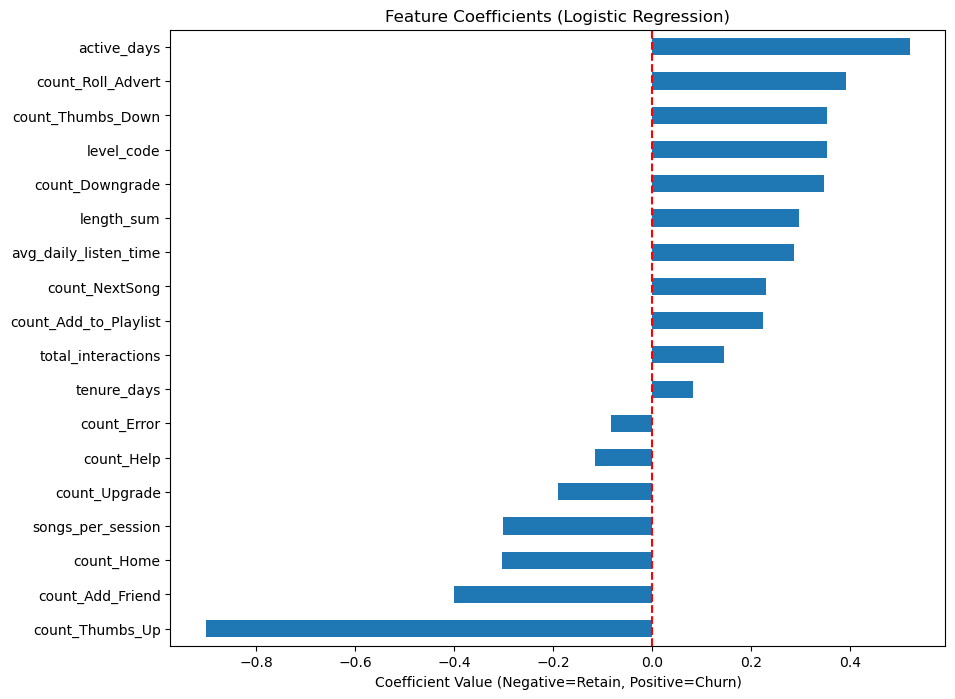

In [29]:
coefs = pd.Series(lr_model.coef_[0], index=selected_features)
coefs_sorted = coefs.sort_values()
plt.figure(figsize=(10, 8))
coefs_sorted.plot(kind='barh')
plt.title("Feature Coefficients (Logistic Regression)")
plt.xlabel("Coefficient Value (Negative=Retain, Positive=Churn)")
plt.axvline(x=0, color='red', linestyle='--')
plt.show()

In [30]:
def make_test_valid_logs_full_history(test_logs: pd.DataFrame) -> pd.DataFrame:
    valid = test_logs.copy()
    max_date = valid["time"].max()
    valid["anchor_date"] = max_date
    valid["target_x"] = 0  # dummy, to reuse aggregate_features
    valid["day"] = pd.to_datetime(valid["time"]).dt.date
    return valid

test_valid_logs = make_test_valid_logs_full_history(test_df)
test_data_final = aggregate_features(test_valid_logs)

In [31]:
# all test users (must be 2904)
all_test_users = test_df.index.unique()

# ensure test_data_final has one row per test user (missing -> 0)
test_data_final = test_data_final.reindex(all_test_users, fill_value=0)

# Build X_test with EXACT same columns as X_train
X_test = test_data_final.drop(columns=["target_x"], errors="ignore")

# align columns: missing -> 0, extra dropped
X_test_aligned = X_test.reindex(columns=X.columns, fill_value=0)

# scale using TRAIN scaler
X_test_scaled = scaler.transform(X_test_aligned)

# apply same selected features mask (RFE)
X_test_sel = selector.transform(X_test_scaled)

In [32]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

val_proba = lr_model.predict_proba(X_val_sel)[:, 1]

thresholds = np.linspace(0.05, 0.95, 19)

rows = []

for t in thresholds:
    val_pred_t = (val_proba >= t).astype(int)

    rows.append({
        "threshold": round(t, 2),
        "precision_1": precision_score(y_val, val_pred_t, zero_division=0),
        "recall_1": recall_score(y_val, val_pred_t),
        "f1_1": f1_score(y_val, val_pred_t),
        "fp": confusion_matrix(y_val, val_pred_t)[0, 1],
        "fn": confusion_matrix(y_val, val_pred_t)[1, 0],
    })

threshold_df = pd.DataFrame(rows).sort_values("f1_1", ascending=False)
threshold_df

,threshold,precision_1,recall_1,f1_1,fp,fn
12,0.65,0.132275,0.413223,0.200401,328,71
11,0.60,0.120000,0.471074,0.191275,418,64
14,0.75,0.147059,0.247934,0.184615,174,91
10,0.55,0.106688,0.553719,0.178905,561,54
13,0.70,0.127737,0.289256,0.177215,239,86
9,0.50,0.098750,0.652893,0.171553,721,42
15,0.80,0.149254,0.165289,0.156863,114,101
8,0.45,0.083883,0.735537,0.150592,972,32
16,0.85,0.182927,0.123967,0.147783,67,106
7,0.40,0.069900,0.809917,0.128693,1304,23


In [33]:
# ===== choose threshold here =====
THRESHOLD = 0.5

# 1) predict probabilities
test_proba = lr_model.predict_proba(X_test_sel)[:, 1]

# 2) apply custom threshold
test_pred = (test_proba >= THRESHOLD).astype(int)

# 3) build submission
submission = pd.DataFrame({
    "id": X_test_aligned.index.astype(int),
    "target": test_pred
})

print("submission rows:", submission.shape[0])  # should be 2904
print("churn rate in submission:", submission["target"].mean())

submission.to_csv(
    f"submission_modified_riskset40_thr{int(THRESHOLD*100)}.csv",
    index=False
)

submission.head()

submission rows: 2904
churn rate in submission: 0.5860881542699724


,id,target
0,1465194,1
1,1261737,0
2,1527155,1
3,1507202,1
4,1429412,1
